# `YData Synthetic` and `Data Profiler`: Streamlined data synthesis and profiling
`YData Synthetic` provides tools for quickly setting up a data synthesis project, trying out different models, datasets and parameterizations.
It is easy to get lost in the process of experimentation and model tweaking but, in the end of the day, quality assessment is extremely important and should not be disregarded, we need to validate that the synthetic data is suitable for our purposes, right?

When assessing the quality of the synthetic outputs we focus on two main aspects:
* Privacy, does the generated data leak any sensitive information? (Names, addresses, combinations of features that can make a real world record identifiable)
* Utility, how well does the synthetic data preserve the original data properties? (Marginal distributions, correlations)

There are no simple ways of doing this important part of the work from scratch, that is why we are showing you today a good adition to your toolbox!
This notebook shows you how to integrate the [Data Profiler](https://github.com/capitalone/DataProfiler) package on a `YData Synthetic` project. By combining these two packages you can easily synthesize data and profile it to assess the quality of the generated data.

The demo will take the following steps:
1. Install `DataProfiler` and import required packages
2. Read a dataset
3. Profile the dataset
4. Define and fit a synthesizer
5. Sample and profile synthetic data
6. Compare sample profiles with `Profiler`'s `diff` method
7. Compare marginal distributions with the `Graph` module
8. Saving/loading a profile for later analysis
9. Wrap-up

That's enough for an introduction, let's get started!

## 1. Install `DataProfiler` and import required packages
`DataProfiler` is a package that helps you doing data analysis with an emphasis on profiling and sensitive data detection.
On this demo we will use the slimmer version and leverage `Profiler` reports and graphical utilities, we will focus on the utility aspect.

To install the package we just need to uncomment and run the following cell:

In [1]:
#!pip install DataProfiler[reports]

Now we import all the required packages for this notebook.

In [2]:
from pprint import pprint
import matplotlib.pyplot as plt

from pandas import read_csv
from ydata_synthetic.synthesizers.regular import WGAN_GP
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from dataprofiler import Profiler, graphs

If you are using GPU you might need to configure your system to allow memory growth:

In [3]:
from tensorflow import config
physical_devices = config.list_physical_devices('GPU') 
for device in physical_devices:
    config.experimental.set_memory_growth(device, True)

## 2. Read a dataset
Lets say we have a credit card transaction dataset and we want to develop a fraudulent transaction classifier, fortunately our dataset is labelled and it looks like this:

In [4]:
data = read_csv('../../data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


How many labelled records do we have? And how balanced is the class feature?

In [5]:
data.Class.map({0: 'Not fraudulent', 1: 'Fraudulent'}).value_counts()

Not fraudulent    284315
Fraudulent           492
Name: Class, dtype: int64

It seems that less than 0.2% of the records are fraudulent, would our model learn from such few examples?

We might need more examples of the minority class, lets select these and synthesize some more.

In [6]:
# Subsetting the fraudulent examples
data = data.loc[data.Class == 1].drop('Class', axis=1)

## 3. Profile the dataset
At this point we probably want to learn a bit more about our data, we can have a look at what `DataProfiler` can provide.

The `Profiler` is the main class that unlocks data analysis.

Depending on the passed data object either an `UnstructuredProfiler`, specialized for text data, or a `StructuredProfiler`, specialized for tabular data, will be automatically dispatched.

Creating a `Profiler` for the fraudulent samples is simple.

In [7]:
profile = Profiler(data)

INFO:DataProfiler.profilers.profile_builder: Finding the Null values in the columns...  (with 11 processes)


100%|██████████| 30/30 [00:00<00:00, 2463.95it/s]


INFO:DataProfiler.profilers.profile_builder: Calculating the statistics...  (with 4 processes)


100%|██████████| 30/30 [00:02<00:00, 11.57it/s]


The `report` method of the `Profiler` allows us to obtain inferred information and statistics in a global (dataset) and data specific (column/row) level.

There is a lot of information to unpack from this object, we will focus on what is most informative to our task.

In [8]:
base_report = profile.report()
pprint({k:v for k,v in base_report['global_stats'].items() if k!='chi2_matrix'})

{'column_count': 30,
 'correlation_matrix': None,
 'duplicate_row_count': 19,
 'encoding': None,
 'file_type': "<class 'pandas.core.frame.DataFrame'>",
 'profile_schema': defaultdict(<class 'list'>,
                               {'Amount': [29],
                                'Time': [0],
                                'V1': [1],
                                'V10': [10],
                                'V11': [11],
                                'V12': [12],
                                'V13': [13],
                                'V14': [14],
                                'V15': [15],
                                'V16': [16],
                                'V17': [17],
                                'V18': [18],
                                'V19': [19],
                                'V2': [2],
                                'V20': [20],
                                'V21': [21],
                                'V22': [22],
                                'V23'

From the global part of the report we can see that we have some duplicated rows, no missing values and some general information about our schema.

Nothing alarming here, lets look at the feature level information.

In [9]:
def summarize_data_stats(data_stats):
    "This function will help us preserving only the most indicative elements of the report in our analysis."
    summarized = {}
    stats_exclude_keys = ['avg_predictions', 'data_label_representation', 'data_type_representation', 'histogram', 'times', 'precision', 'label_representation']
    for feat_info in data_stats:
        name = feat_info['column_name']
        stats = {k: v for k, v in feat_info.pop('statistics').items() if k not in stats_exclude_keys}
        feat_info['statistics'] = stats
        summarized[name] = feat_info
    return summarized
        
pprint(summarize_data_stats(base_report['data_stats']))

{'Amount': {'categorical': False,
            'column_name': 'Amount',
            'data_label': 'FLOAT',
            'data_type': 'float',
            'order': 'random',
            'samples': ['39.9', '261.87', '294.9', '1.0', '592.9'],
            'statistics': {'kurtosis': 17.74568735518795,
                           'max': 2125.87,
                           'mean': 122.21132113821139,
                           'median': 9.832148749999996,
                           'median_abs_deviation': 9.592725272277224,
                           'min': 0.0,
                           'mode': [1.062935],
                           'null_count': 0,
                           'null_types': [],
                           'null_types_index': {},
                           'num_negatives': 0,
                           'num_zeros': 27,
                           'precision': {'confidence_level': 0.999,
                                         'margin_of_error': 0.243363,
                        

Two key aspects that pop out:
* There are plenty of duplicate values in the time and amount features, this might be a typical pattern in fraudulent transactions
* The rich statistical summary should help us make a good assessment of the quality of synthetic samples later on

## 4. Define and fit a synthesizer
From the `YData Synthetic` library we will define a Wasserstein GAN with Gradient Penalty, `WGAN_GP`, that we can use to generate synthetic fraudulent records:

In [10]:
# Define Model Parameters
batch_size = 128
learning_rate = 5e-4
beta_1 = 0.5
beta_2 = 0.9
noise_dim = 32
dim = 128

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           betas=(beta_1, beta_2),
                           noise_dim=noise_dim,
                           layers_dim=dim)

# Define Train Parameters
epochs = 500

train_args = TrainParameters(epochs=epochs)

# Instantiate synthesizer
synthesizer = WGAN_GP(gan_args, n_critic=2)

We fit the synthesizer by running the `train` method.

In [ ]:
synthesizer.train(data, train_args, num_cols=list(data.columns), cat_cols=None)

## 5. Sample and profile synthetic data
After training the synthesizer we can now obtain synthetic fraudulent transactions with the `sample` method.

In [12]:
synth_data = synthesizer.sample(len(data)).iloc[:len(data)]

Synthetic data generation: 100%|██████████| 4/4 [00:00<00:00, 473.52it/s]


As simple as for the real data we can create a `Profiler` with our new sample.

In [13]:
synth_profile = Profiler(synth_data)

INFO:DataProfiler.profilers.profile_builder: Finding the Null values in the columns...  (with 11 processes)


100%|██████████| 30/30 [00:00<00:00, 2955.96it/s]


INFO:DataProfiler.profilers.profile_builder: Calculating the statistics...  (with 4 processes)


  3%|▎         | 1/30 [00:00<00:03,  8.64it/s]

100%|██████████| 30/30 [00:02<00:00, 11.18it/s]


## 6. Compare sample profiles with `Profiler`'s `diff` method
Now we get to part of the utility assessment.

The `diff` method of the `Profiler` allows us to obtain a description of the differences between two data profiles, as long as they share the same schema. This allows us to get a glimpse of the similarities between two samples, a useful way to compare synthetic samples with the real data!

In [14]:
synth_diff_report = profile.diff(synth_profile)

In [15]:
pprint(synth_diff_report['global_stats'])

{'chi2_matrix': 'unchanged',
 'column_count': 'unchanged',
 'correlation_matrix': None,
 'duplicate_row_count': 19.0,
 'encoding': 'unchanged',
 'file_type': 'unchanged',
 'profile_schema': [{},
                    {'Amount': 'unchanged',
                     'Time': 'unchanged',
                     'V1': 'unchanged',
                     'V10': 'unchanged',
                     'V11': 'unchanged',
                     'V12': 'unchanged',
                     'V13': 'unchanged',
                     'V14': 'unchanged',
                     'V15': 'unchanged',
                     'V16': 'unchanged',
                     'V17': 'unchanged',
                     'V18': 'unchanged',
                     'V19': 'unchanged',
                     'V2': 'unchanged',
                     'V20': 'unchanged',
                     'V21': 'unchanged',
                     'V22': 'unchanged',
                     'V23': 'unchanged',
                     'V24': 'unchanged',
                     'V2

Two things pop out:
* The schema was completely preserved
* The synthetic samples do not have duplicate rows, hence the difference remained equal to the real data profile values. An expected behavior of a GAN synthesizing float values without post processing is that duplicates are highly unlikely


In [21]:
pprint(summarize_data_stats(synth_diff_report['data_stats']))

{'Amount': {'categorical': 'unchanged',
            'column_name': 'Amount',
            'data_label': [['FLOAT'], [], ['BAN']],
            'data_type': 'unchanged',
            'order': 'unchanged',
            'statistics': {'label_representation': {'ADDRESS': 'unchanged',
                                                    'BAN': -0.8678861788617886,
                                                    'CREDIT_CARD': -0.01016260162601626,
                                                    'DATE': 'unchanged',
                                                    'DATETIME': 'unchanged',
                                                    'DRIVERS_LICENSE': -0.006097560975609756,
                                                    'EMAIL_ADDRESS': 'unchanged',
                                                    'FLOAT': 0.5772357723577236,
                                                    'HASH_OR_KEY': 'unchanged',
                                                    'INTEGER': 'unc

## 7. Compare marginal distributions with the `Graph` module
The `Graph` module contains some plotting functions that can be used in detecting missing values with `plot_missing_values_matrix` or comparing marginal distributions with `plot_histograms` method. The latter is another useful way of validating the quality of synthetic samples.

These methods return `matplotlib` figures which also allows you to do some further customization.

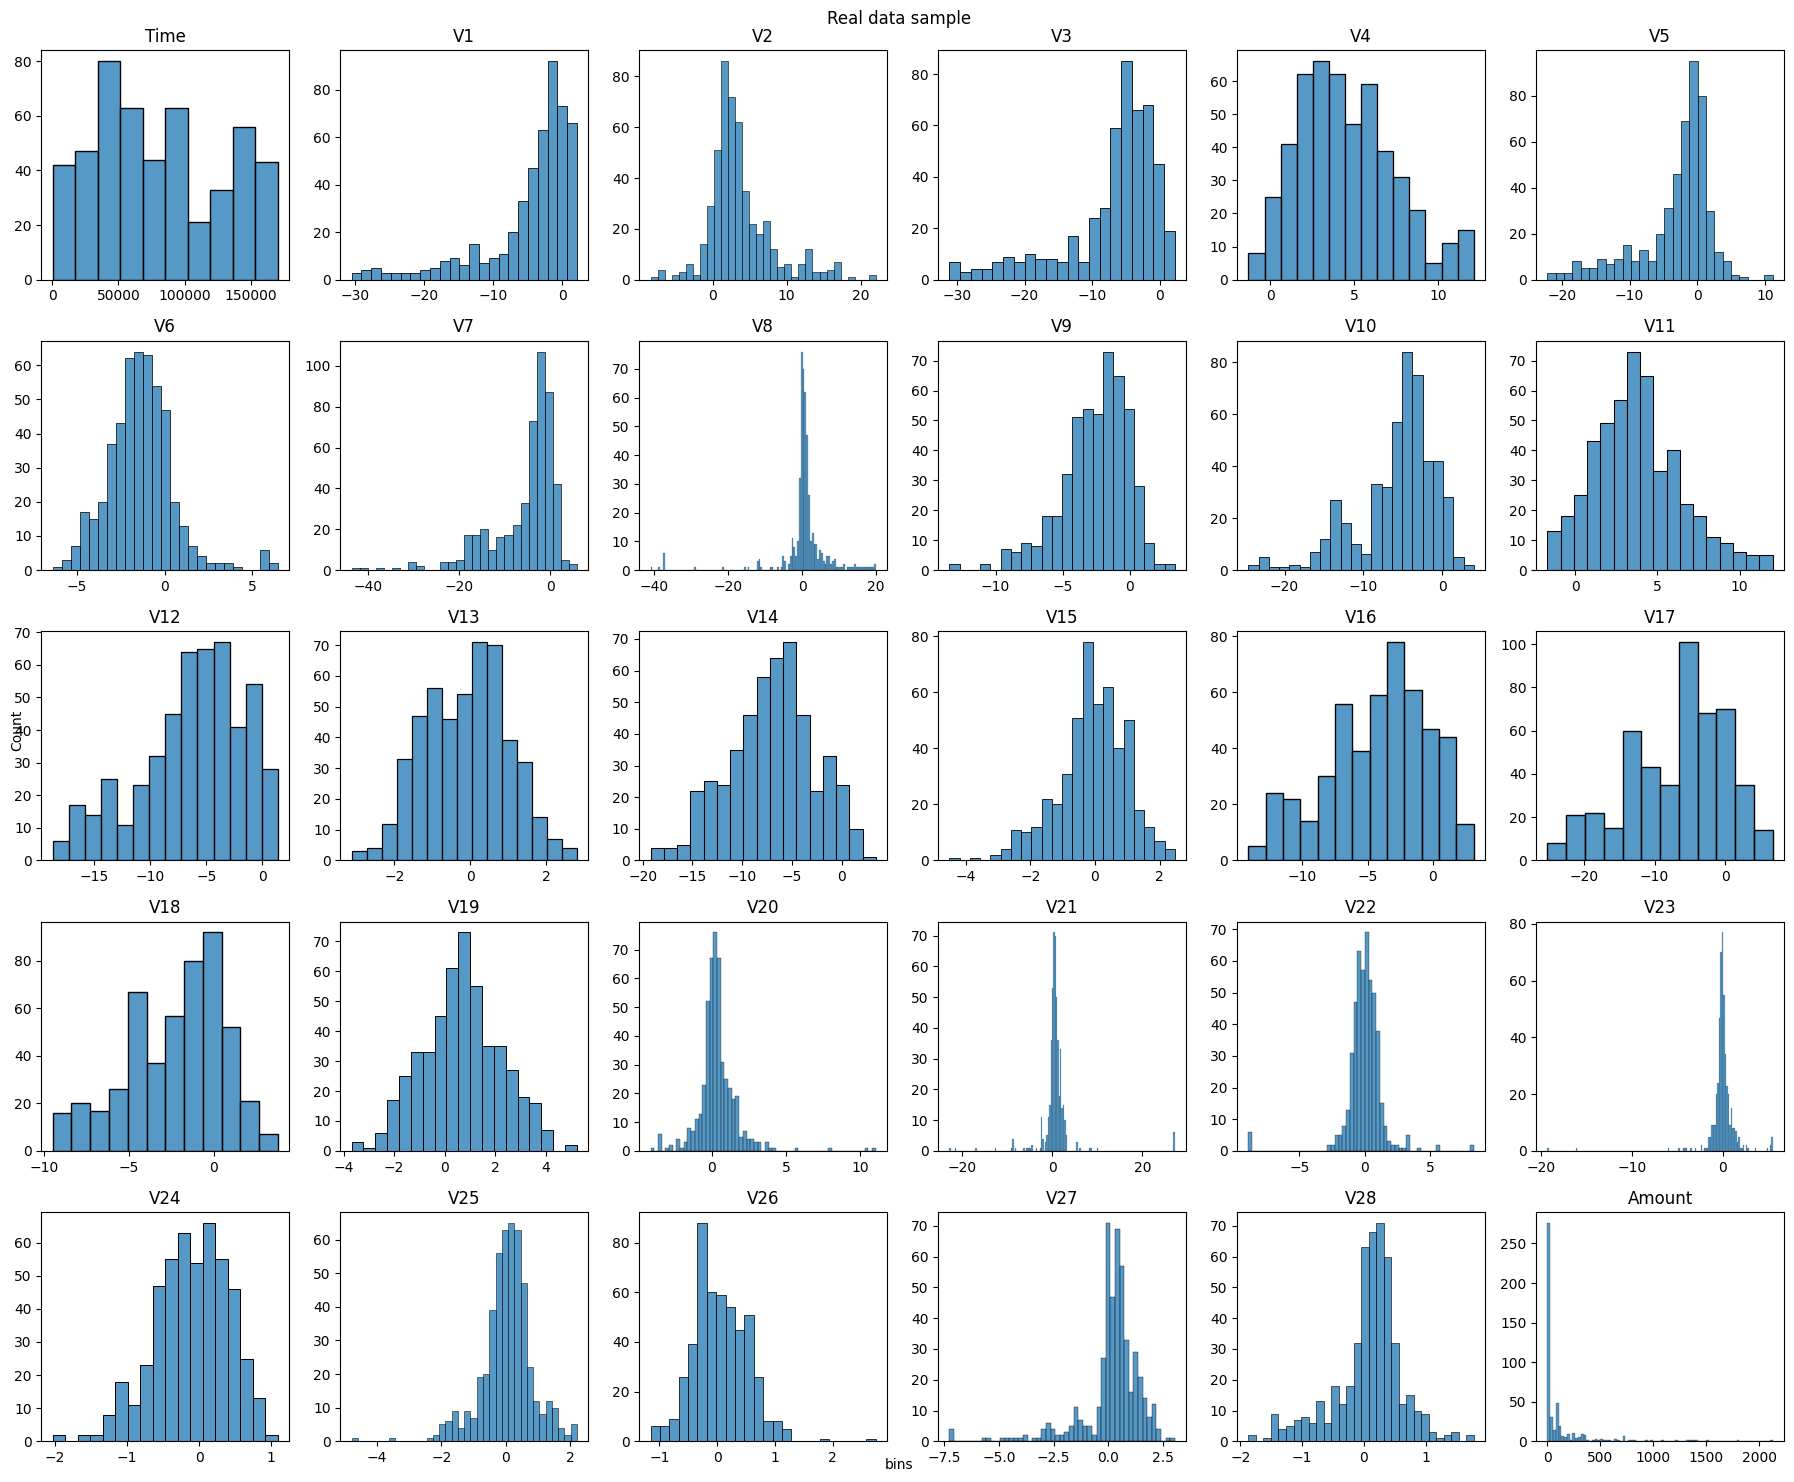

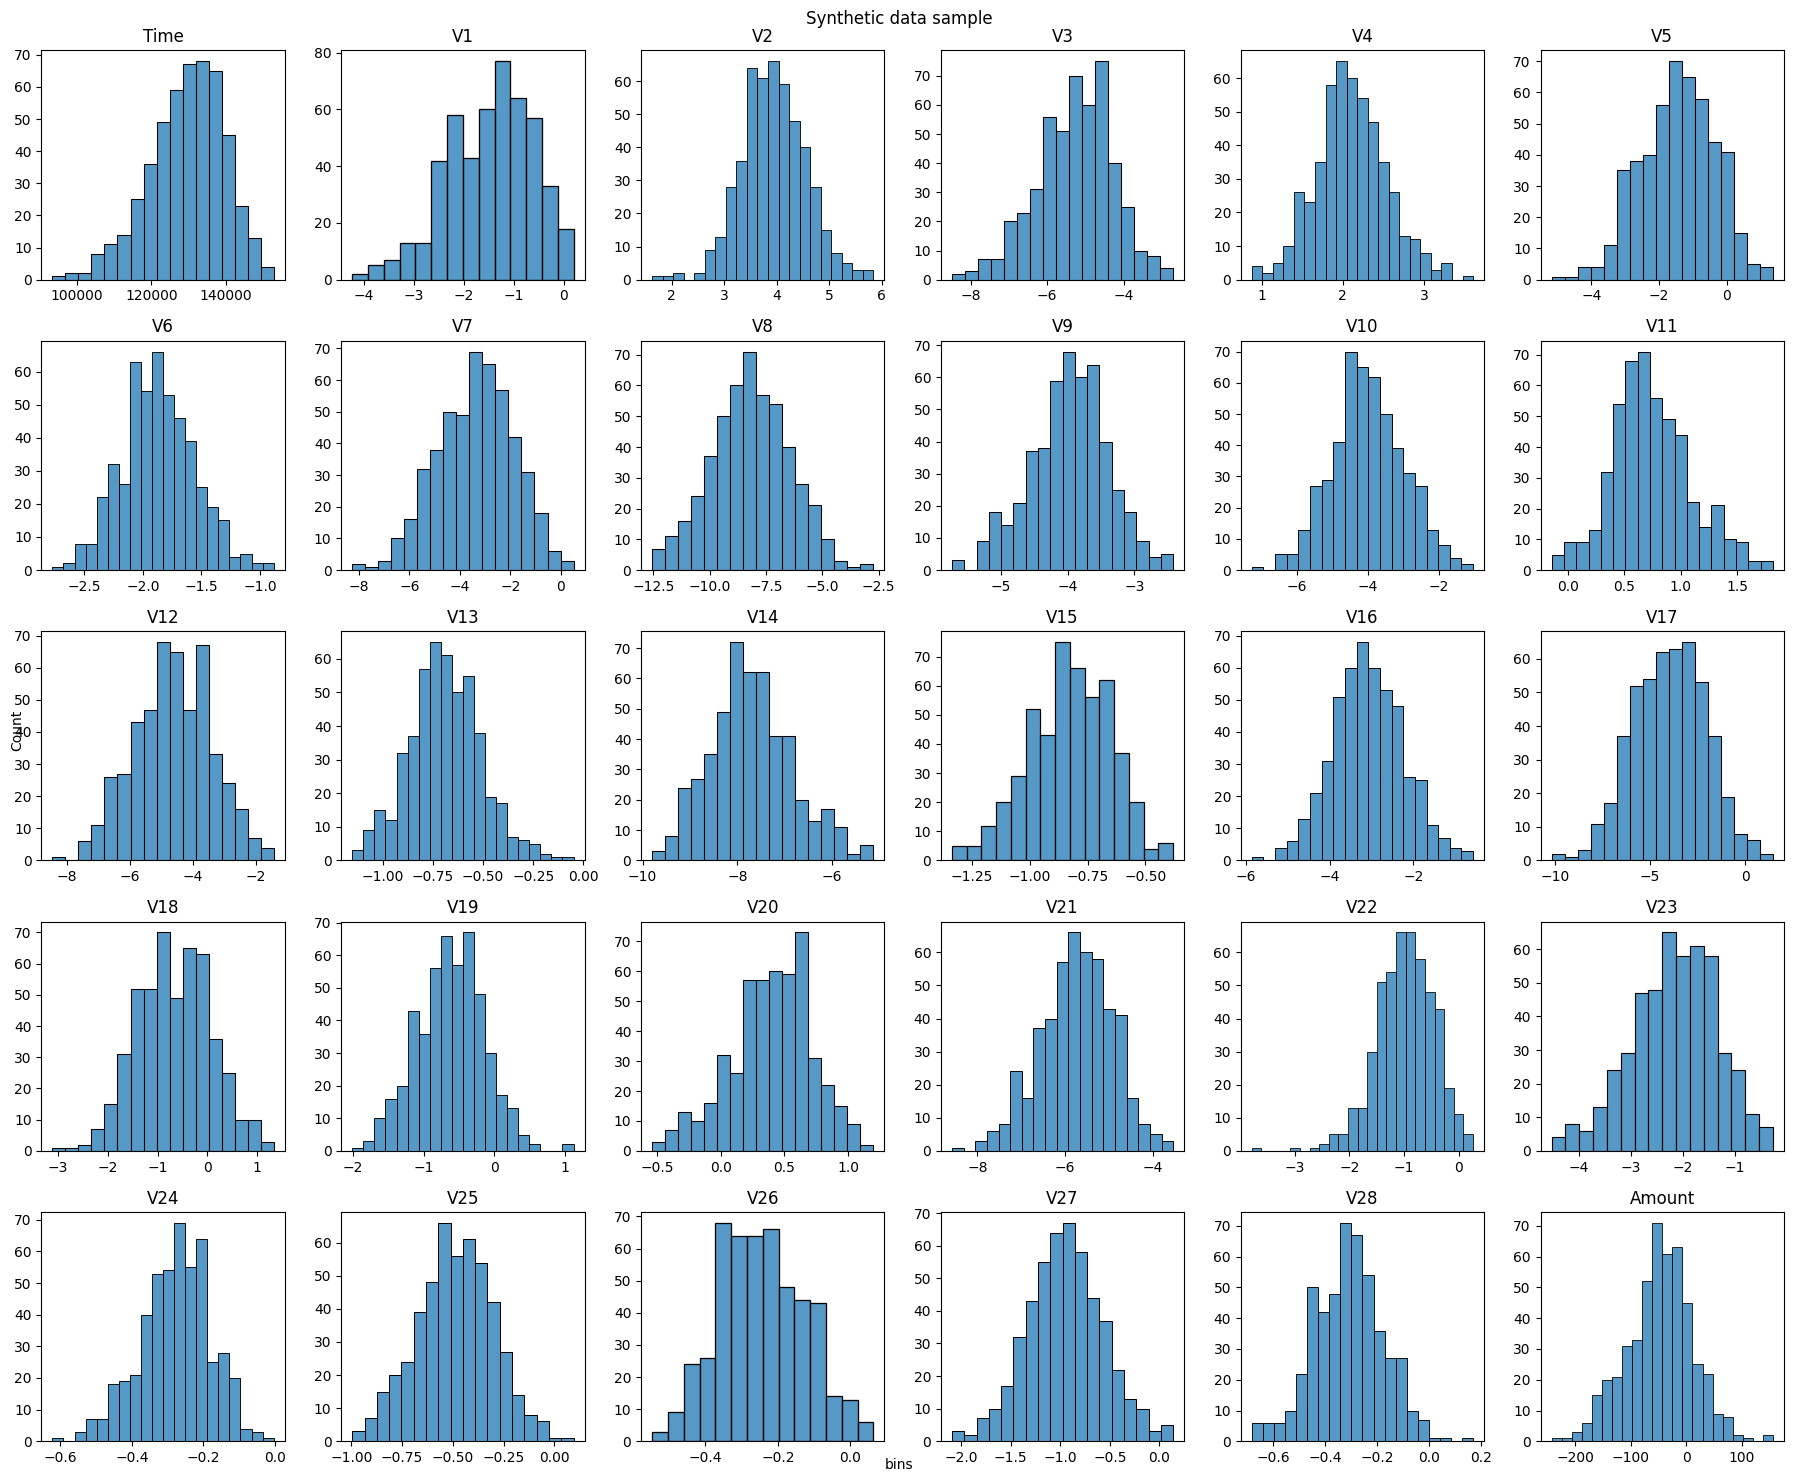

In [22]:
plt.rcParams["figure.figsize"] = (18,15)

real_fig = graphs.plot_histograms(profile)
real_fig.suptitle('Real data sample')
real_fig.tight_layout()

synth_fig = graphs.plot_histograms(synth_profile)
synth_fig.suptitle('Synthetic data sample')
synth_fig.tight_layout()

plt.show()

The shape of the marginals seem to be overall respected, some features have better adjustment than others but there is room for optimization overall.

The histogram panel allows us to visually detect which features are being expressed in the expected ranges and with the right shape attributes like skewness and kurtosis.

## 8. Saving/loading a profile for later analysis
`DataProfiler` also allows saving and loading profiles. This is another a useful feature for your `YData Synthetic` projects. To save a profile you can use the `Profiler`'s `save` method.

As an example, we can save the synthesizer and the synthetic data sample profile from this session and continue the comparison after another batch of experiments.

In [18]:
synth_profile.save(filepath='synthetic_data_profile.pkl')
synthesizer.save(path='synthesizer.pkl')

Reloading data profiles with the `load` method is easy as well:

In [19]:
synth_profile = Profiler.load(filepath='synthetic_data_profile.pkl')

## 9. Wrap-up
`DataProfiler` has a set of tools that are good additions to your Machine Learning flows.
We worked on a fraudulent credit card transactions dataset and made some of synthetic records. With the help of the `Profiler` class we assessed the utility of the synthetic samples. We learned how to save and reload the profiles for later which in this case could come in handy in case we want to extend our experiments with more models or parameterizations.

We hope this notebook has demonstrated the capacities of the `DataProfiler` package and how you can use it in the context of a `YData Synthetic` project. 